# Fourier Interpolation
This will be a working notebook on using the Fourier transform to interpolate images based on the work of Hagelberg et al. 2015.

The basic idea property of Fourier Transforms that we'll exploit is the "Translation property" of Fourier transforms. If $F(v)$ is the Fourier transform of the 1D function $f(x)$ then the Fourier transform of $f(x+a)$ is $\exp(-i2\pi v a)F(v)$. Thus for a shift along the x-axis we have
$f(x+a,y) = \int_{-\infty}^{\infty} e^{-i2\pi v_x a} F(v_x,y) e^{i 2 \pi (v_x x)} dv_x$

The general case in 2D is

$f(x+a, y+b) = \int \int_{-\infty}^{\infty} e^{-i 2 \pi (v_x a + v_y b)} F(v_x, v_y) e^{i 2 \pi (v_x x + v_y y)}dv_x dv_y$

## 1D shift

In [106]:
from pathlib import Path

# Path to the yield input package directory
# yip_path = Path("../../input/LUVOIR-B-VC6_timeseries")
yip_path = Path("../../input/coronagraphs/usort")
# Loading the offax_psf files directly
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from lod_unit import lod # NOTE: `lod` is an astropy unit for lambda/D, I defined it enough that I made it a package

offax_psf_data = pyfits.getdata(Path(yip_path, "offax_psf.fits"))
offax_psf_offsets_list = pyfits.getdata(Path(yip_path, "offax_psf_offset_list.fits"))

psf = offax_psf_data[0]

So let's implement the equation

$f(x+a,y) = \int_{-\infty}^{\infty} e^{-i2\pi v_x a} F(v_x,y) e^{i 2 \pi (v_x x)} dv_x$

Some important conceptual notes before starting:
1. $x$, $a$, and $y$ are in pixels (or whatever the starting array's units are)
2. $v_x$ and $v_y$ are frequency domain transforms of $x$ and $y$, giving them units of $\frac{\text{pixels}}{\text{cycle}}$
3. At a high level what we are doing is applying a tilt, the Zernicke mode, to the focal plane of our image to change the pupil plane. This works because a tilt in the focal plane corresponds to a change in angle in the pupil plane.

Number of x pixels: 256


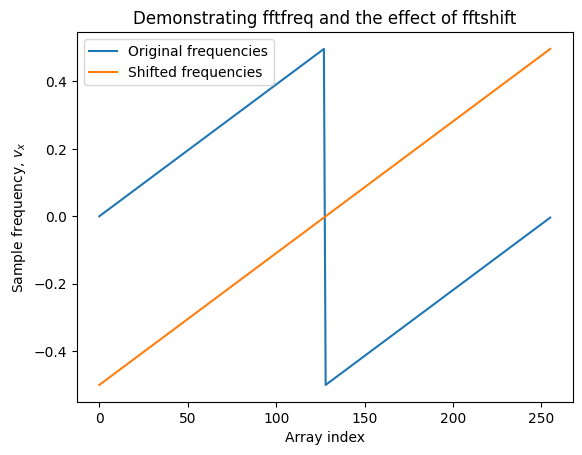

In [222]:
# Number of pixels to shift along the x
a = 80

# The number of x pixels
cols = psf.shape[1]
print(f"Number of x pixels: {cols}")

# Get the sample frequencies that the Discrete Fourier Transform will use (along the x axis)
# Also the frequency bin centers
x_freqs = fftfreq(cols)

# Center the frequences
# e.g. [0, 1, 2, ..., 5, -5, -4, ..., -1] is changed to
# [-5, -4, ..., 0, 1, ..., 5]
v_x = fftshift(x_freqs)

# Example plot of the change
inds = np.arange(cols)
fig,ax = plt.subplots()
ax.plot(inds, x_freqs, label='Original frequencies')
ax.plot(inds, v_x, label='Shifted frequencies')
ax.set_xlabel("Array index")
ax.set_ylabel("Sample frequency, $v_x$")
ax.set_title("Demonstrating fftfreq and the effect of fftshift")
ax.legend()
plt.show()

Next, since we are in 2d, we create a tiled version of the sample frequencies so that it applies to all rows of the image. It's important to note that the equations above have all shown a scalar value, such as $f(x,y)$, but we are shifting the entire image and not a single pixel so we will work with arrays. Let's create the array of $v_x$ values.

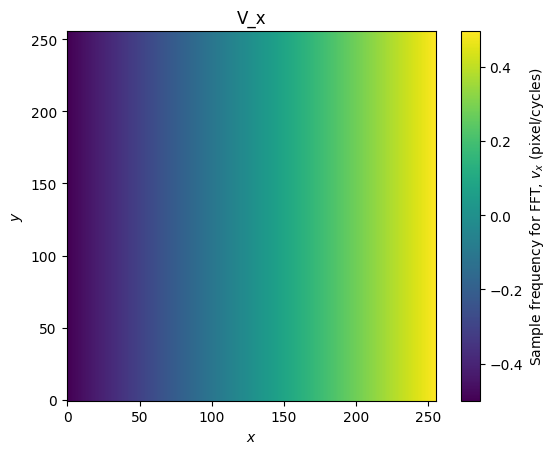

In [228]:
V_x = np.tile(v_x, (cols, 1))

fig, ax = plt.subplots()
f = ax.imshow(V_x, origin='lower')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("V_x")
fig.colorbar(f, label='Sample frequency for FFT, $v_x$ (pixel/cycles)')
plt.show()

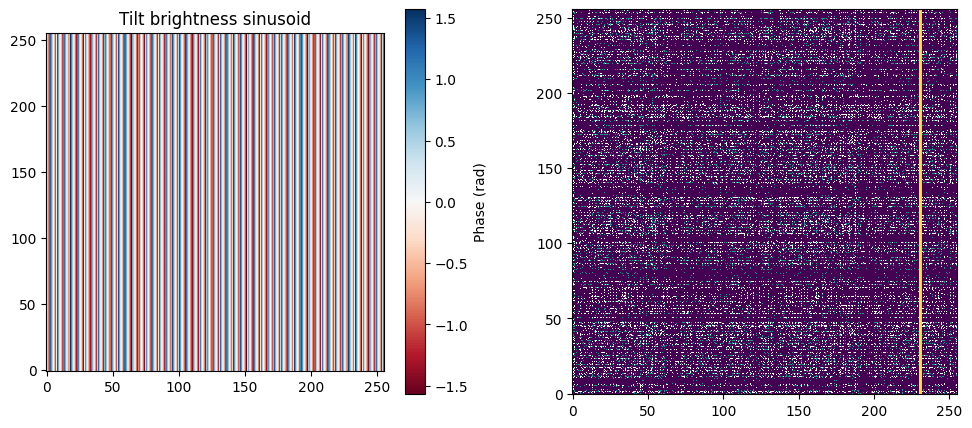

In [275]:
# This changes the frequency of the tilt
pixels_to_shift = 25

# Create the brightness sinusoid with spatial frequency of pixels_to_shift/
translation_fact = np.exp(-2j*np.pi * (pixels_to_shift * V_x))

phase = np.arctan(translation_fact.imag/translation_fact.real)
intensity = np.abs(translation_fact)**2

# Plot the brightness sinusoid
cmap = plt.get_cmap('RdBu')
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
f = axes[0].imshow(phase, origin='lower', cmap=cmap)
axes[0].set_title("Tilt brightness sinusoid")
fig.colorbar(f, label='Phase (rad)')

# Plot the Fourier transform
axes[1].imshow(np.abs(fft(translation_fact))**2, origin='lower', norm=LogNorm())

plt.show()

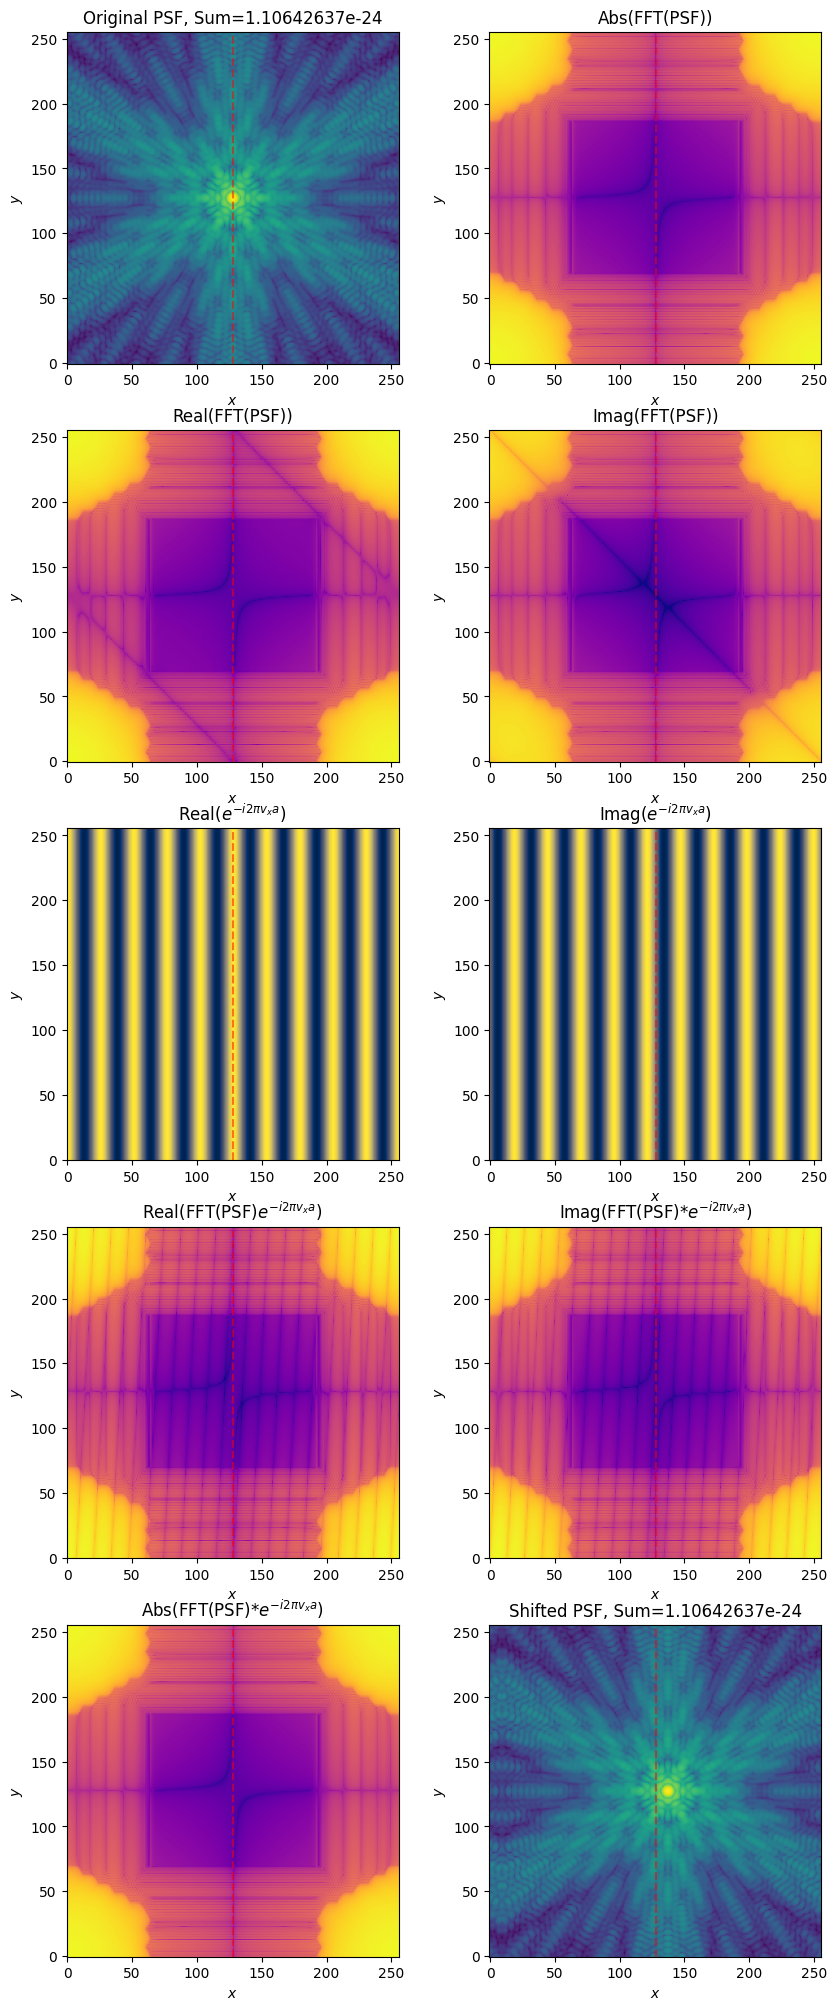

In [217]:
# Pixels to shift in X direction
shift_x = 10

# The number of x pixels
cols = psf.shape[1]

# Get the sample frequencies
x = fftfreq(cols)

# This moves the center of the frequency array
sh_x = fftshift(x)

X = np.tile(sh_x, (cols, 1))
translation_fact = np.exp(-2j*np.pi * (shift_x * X))

# Calculate the FFT of the PSF
fft_psf = fft2(psf)

# Multiply the FFT by the translation phasor
shifted_fft_psf = fft_psf*translation_fact

# Get the final PSF
oned_shift = np.abs(ifft2(shifted_fft_psf))


### Plotting
cmap_psf = plt.get_cmap('viridis')
cmap_fft = plt.get_cmap('plasma')
cmap_phasor = plt.get_cmap("cividis")

norm_psf = LogNorm(vmin=psf.min(), vmax=psf.max())
norm_phasor = LogNorm()
norm_fft = LogNorm(vmin=np.abs(fft_psf).min(), vmax=np.abs(fft_psf).max())

base_labels = {"xlabel": "$x$", "ylabel": "$y$"}
fft_labels = {"xlabel": "$x$", "ylabel": "$y$"}

fig, (axes_orig, axes_orig_ffts, axes_phasor, axes_modified_ffts, axes_final) = plt.subplots(ncols=2, nrows=5, figsize=(10,25))

# Show the original information
axes_orig[0].imshow(psf, origin='lower', norm=norm_psf, cmap=cmap_psf)
axes_orig[0].set_title(f"Original PSF, Sum={np.sum(psf):.8e}")
axes_orig[1].imshow(np.abs(fft_psf), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_orig[1].set_title(f"Abs(FFT(PSF))")

axes_orig_ffts[0].imshow(np.abs(fft_psf.real), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_orig_ffts[0].set_title(f"Real(FFT(PSF))")
axes_orig_ffts[1].imshow(np.abs(fft_psf.imag), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_orig_ffts[1].set_title(f"Imag(FFT(PSF))")

axes_phasor[0].imshow(translation_fact.real, origin='lower', cmap=cmap_phasor)
axes_phasor[0].set_title(f"Real($e^{{-i 2 \pi v_x a}}$)")
axes_phasor[1].imshow(translation_fact.imag, origin='lower', cmap=cmap_phasor)
axes_phasor[1].set_title(f"Imag($e^{{-i 2 \pi v_x a}}$)")

axes_modified_ffts[0].imshow(np.abs(shifted_fft_psf.real), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_modified_ffts[0].set_title(f"Real(FFT(PSF)$e^{{-i 2 \pi v_x a}}$)")
axes_modified_ffts[1].imshow(np.abs(shifted_fft_psf.imag), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_modified_ffts[1].set_title(f"Imag(FFT(PSF)*$e^{{-i 2 \pi v_x a}}$)")

axes_final[0].imshow(np.abs(shifted_fft_psf), origin='lower', norm=norm_fft, cmap=cmap_fft)
axes_final[0].set_title("Abs(FFT(PSF)*$e^{{-i 2 \pi v_x a}}$)")
axes_final[1].imshow(oned_shift, origin='lower', norm=norm_psf, cmap=cmap_psf)
axes_final[1].set_title(f"Shifted PSF, Sum={np.sum(oned_shift):.8e}")


fft_axes = [axes_orig[1], *axes_orig_ffts, *axes_phasor, *axes_modified_ffts, axes_final[0]]
for ax in fft_axes:
    ax.set(**fft_labels)
    ax.axvline(cols//2, ls='--', color='r', alpha=0.5)

base_axes = [axes_orig[0], axes_final[1]]
for ax in base_axes:
    ax.set(**base_labels)
    ax.axvline(cols//2, ls='--', color='r', alpha=0.5)
#axes_intermediate[1].imshow(np.abs(shifted_fft_psf), origin='lower', norm=norm2)
#axes_intermediate[1].set_title(f"Translated FFT")


#abs_fft = np.abs(fft_psf)

#axes_fft[1].imshow(np.abs(shifted_fft_psf), origin='lower', norm=norm2)
#axes_fft[1].set_title(f"Translated FFT")
#axes_fft[2].imshow(np.abs(shifted_fft_psf-fft_psf), origin='lower', norm=norm2)
#axes_fft[2].set_title(f"Difference")
#plt.show()

In [199]:
ax.

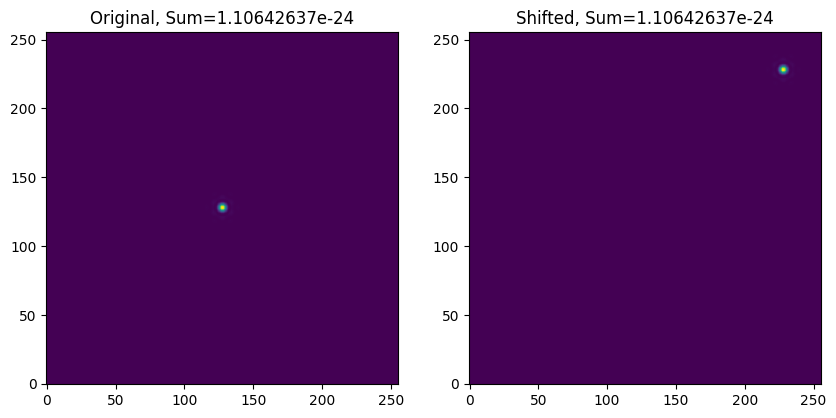

In [83]:
shift_x = 100
shift_y = 100
rows, cols = psf.shape
fft_psf = fft2(psf)
x = fftfreq(cols)
y = fftfreq(rows)
X, Y = np.meshgrid(x,y)

translation_fact = np.exp(-2j*np.pi * (shift_x * X + shift_y*Y))

fft_psf_shifted = fft_psf*translation_fact
translated = ifft2(fft_psf_shifted)
final_psf = np.abs(translated)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].imshow(psf, origin='lower')
axes[0].set_title(f"Original, Sum={np.sum(psf):.8e}")
axes[1].imshow(final_psf, origin='lower')
axes[1].set_title(f"Shifted, Sum={np.sum(final_psf):.8e}")
plt.show()